### Image Search Exploration

This notebook demonstrates how to configure a MongoDB collection to store vector embeddings.
It then shows how to load images from disk and to use the [clip-ViT-L-14](https://huggingface.co/sentence-transformers/clip-ViT-L-14) multi-modal transformer to create embeddings for each image.

Finally, it demonstrates how to generate a vector embedding from a text phrase, using the same transformer, and to use that to look up appropriate images in the MongoDB collection.

In order to run this notebook, you'll need to set the `MONGODB_URI` environment variable to a connection string for a MongoDB cluster running MongoDB 7.0.2 or above.

In [1]:
# Uncomment the next line to install all the requirements:
#!pip install -r requirements.txt

In [2]:
from glob import glob
from math import ceil
import os
from pathlib import Path
from random import choices
import re

import cv2
import matplotlib.pyplot as plt
from PIL import Image

# I'm using MongoDB as my vector database:
from pymongo import MongoClient
from pymongo.errors import CollectionInvalid, DuplicateKeyError
from pymongo.operations import SearchIndexModel

from sentence_transformers import SentenceTransformer # The transformer used to execute the clip model.
from tqdm.notebook import tqdm                        # Nice progress bars

In [3]:
# These can be modified if they're not appropriate for your cluster:
DATABASE_NAME = "image_search_demo"
IMAGE_COLLECTION_NAME = "images"

# Change this to 1000 to load a suitable number of images into MongoDB:
NUMBER_OF_IMAGES_TO_LOAD = 10

# Set this as an environment variable to avoid accidentally sharing your cluster credentials:
MONGODB_URI = os.environ["MONGODB_URI"]

## Configure the MongoDB Collection

First, connect to the MongoDB cluster, and configure the collection so that the "embedding" field has an appropriate vector search index.

* [How to index your vector embeddings](https://www.mongodb.com/docs/atlas/atlas-search/field-types/knn-vector/)

In [4]:
client = MongoClient(MONGODB_URI)
db = client.get_database(DATABASE_NAME)

# Ensure the collection exists, because otherwise you can't add a search index to it.
try:
    db.create_collection(IMAGE_COLLECTION_NAME)
except CollectionInvalid:
    # This is raised when the collection already exists.
    print("Images collection already exists")

# Add a search index (if it doesn't already exist):
collection = db.get_collection(IMAGE_COLLECTION_NAME)
if len(list(collection.list_search_indexes(name="default"))) == 0:
    print("Creating search index...")
    collection.create_search_index(
        SearchIndexModel(
            {
                "mappings": {
                    "dynamic": True,
                    "fields": {
                        "embedding": {
                            "dimensions": 768,
                            "similarity": "cosine",
                            "type": "knnVector",
                        }
                    },
                }
            },
            name="default",
        )
    )
    print("Done.")
else:
    print("Vector search index already exists")

Images collection already exists
Vector search index already exists


## Load Images Into the Collection

The following section configures the "clip-ViT-L-14" sentence transformer, and then uses it to create embedding vectors for a number of sample images before loading the file path and vector data into MongoDB.

I have a subdirectory called 'images' that contains all my images (in sub-folders). I downloaded my images from [Kaggle's ImageNet 1000 (mini) dataset](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

In [5]:
# Load CLIP model.
# This may print out warnings, which can be ignored.
model = SentenceTransformer("clip-ViT-L-14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
def load_images(image_count=1000):
    """
    Load `image_count` images into the database, creating an embedding for each using the sentence transformer above.

    This can take some time to run if image_count is large.

    The image's pixel data is not loaded into MongoDB, just the image's path and vector embedding.
    """
    image_paths = choices(glob("images/**/*.JPEG", recursive=True), k=image_count)
    for path in tqdm(image_paths):
        emb = model.encode(Image.open(path))
        try:
            collection.insert_one(
                {
                    "_id": re.sub("images/", "", path),
                    "embedding": emb.tolist(),
                }
            )
        except DuplicateKeyError:
            pass


load_images(NUMBER_OF_IMAGES_TO_LOAD)

  0%|          | 0/10 [00:00<?, ?it/s]

## Query the Images in MongoDB

This section defines a function to display images in the notebook, and another function to search MongoDB using user-defined phrases.

There are then some demonstrations of the kinds of results that are returned when using MongoDB's Vector Search feature.

In [7]:
def display_images(docs, cols=3, show_paths=False):
    """
    Helper function to display some images in a grid.
    """
    for doc in docs:
        doc["image_path"] = "images/" + doc["_id"]

    rows = ceil(len(docs) / cols)

    f, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 8), tight_layout=True)
    for i, doc in enumerate(docs):
        image_path = doc["image_path"]
        score = doc["score"]
        image = cv2.imread(image_path)[:, :, ::-1]
        axis = axarr[i // cols, i % cols]
        axis.imshow(image)
        axis.axis("off")
        if show_paths:
            axis.set_title(image_path.rsplit("/", 1)[1])
        else:
            axis.set_title(f"Score: {score:.4f}")
    plt.show()


def image_search(search_phrase):
    """
    Use MongoDB Vector Search to search for a matching image.

    The `search_phrase` is first converted to a vector embedding using
    the `model` loaded earlier in the Jupyter notebook. The vector is then used
    to search MongoDB for matching images.
    """
    emb = model.encode(search_phrase)
    cursor = collection.aggregate(
        [
            {
                "$vectorSearch": {
                    "index": "default",
                    "path": "embedding",
                    "queryVector": emb.tolist(),
                    "numCandidates": 100,
                    "limit": 9,
                }
            },
            {"$project": {"_id": 1, "score": {"$meta": "vectorSearchScore"}}},
        ]
    )

    return list(cursor)

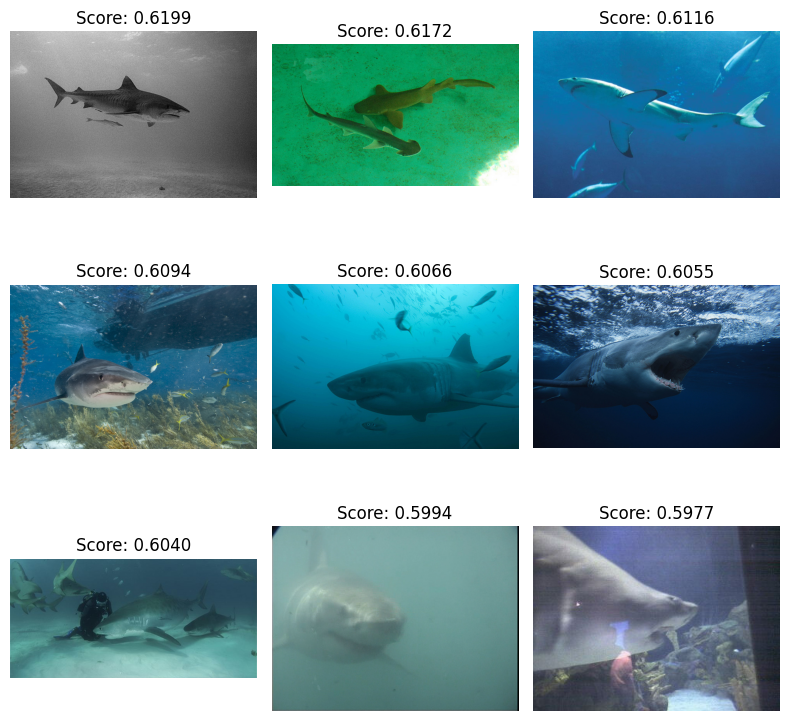

In [8]:
display_images(image_search("sharks in the water"))

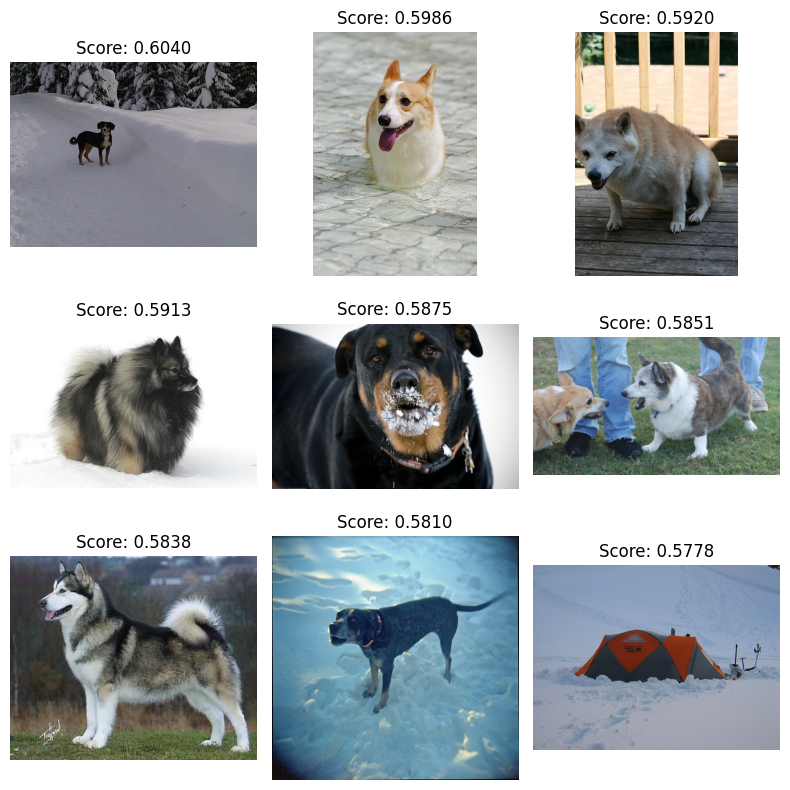

In [9]:
display_images(image_search("corgi in the snow"))

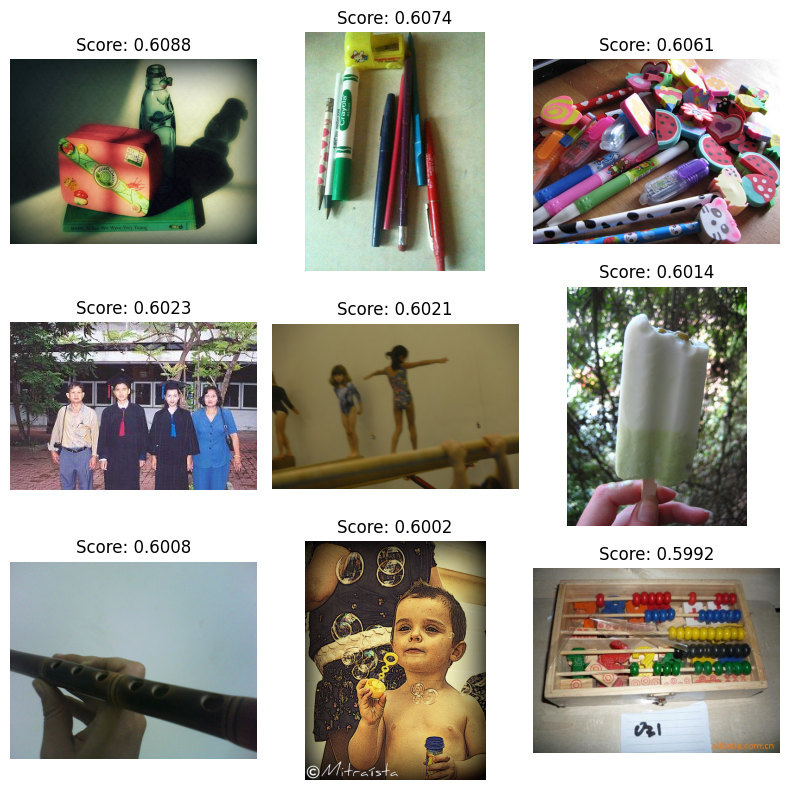

In [10]:
display_images(image_search("childhood"))

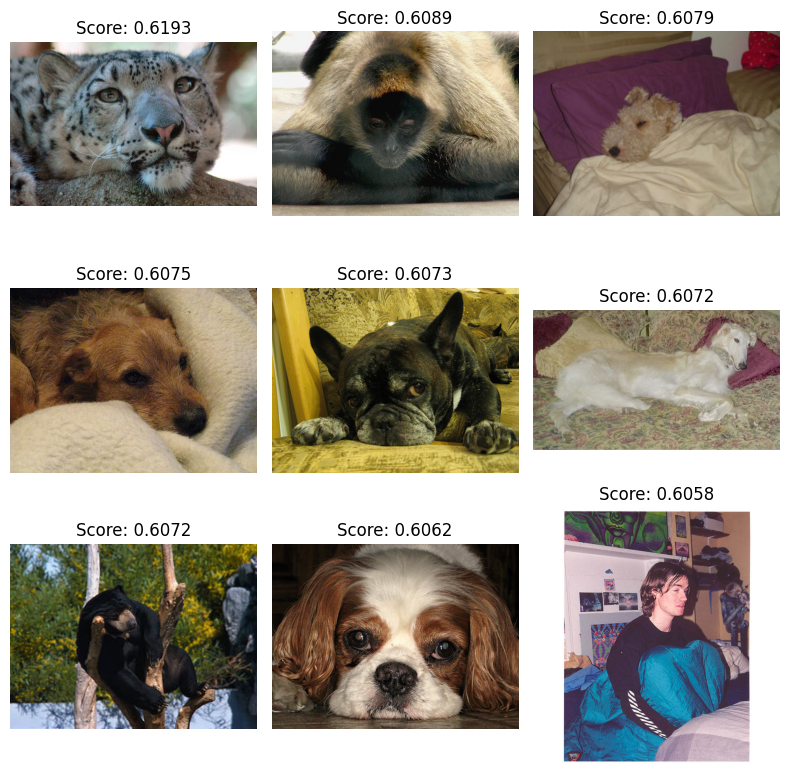

In [11]:
display_images(image_search("ennui"))